In [1]:
#!pip install pmdarima

In [2]:
#importing the relevant libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score 

from warnings import simplefilter
simplefilter("ignore", FutureWarning)


In [3]:
#Reading the 1st dataset, Setting the date_time column as index
cell_=pd.read_csv("climacell_data_formodel.csv",index_col='date_time',parse_dates=True)
cell=cell_
cell

,date,time,irradiance,ambient_temp,wind_speed
date_time,,,,,
2020-08-20 06:05:00+05:30,20-08-2020,06:05:00,0,28.58,6.33
2020-08-20 06:10:00+05:30,20-08-2020,06:10:00,0,28.57,6.26
2020-08-20 06:15:00+05:30,20-08-2020,06:15:00,0,28.57,6.18
2020-08-20 06:20:00+05:30,20-08-2020,06:20:00,0,28.56,6.11
2020-08-20 06:25:00+05:30,20-08-2020,06:25:00,0,28.56,6.03
...,...,...,...,...,...
2020-10-20 11:40:00+05:30,20-10-2020,11:40:00,322,30.24,3.10
2020-10-20 11:45:00+05:30,20-10-2020,11:45:00,322,30.25,3.14
2020-10-20 11:50:00+05:30,20-10-2020,11:50:00,322,30.26,3.19


In [4]:
#Reading the 2nd Dataset, Default index
weather_=pd.read_csv("weather_data_from_plant.csv")
weather=weather_

In [5]:
#Applying data wrangling and engineering techniques to bring the datetime column of the 2nd dataset within the proper format

weather["date"]=weather.date_time.str.split('T').str[0]+" "
weather["time_"]=weather.date_time.str.split('T').str[1]
weather["time"]=weather.time_.str.split('.').str[0]+"+5:30"
weather["date_time"]=weather["date"]+weather["time"]
weather.drop(["date","time","time_"],axis=1,inplace=True)

In [6]:
#Converting the string to datetime format
weather["date_time"]=pd.to_datetime(weather["date_time"])


In [7]:
#checking for any null values within the datset
print(weather.isnull().sum(),cell.isnull().sum())

date_time       0
ambient_temp    0
wind_speed      0
irradiance      0
dtype: int64 date            0
time            0
irradiance      0
ambient_temp    0
wind_speed      0
dtype: int64


In [8]:
#checking the shape of the datset to have an idea about the dimentions
print(weather.shape,cell.shape)

(79912, 4) (2952, 5)


In [9]:
#setting datetime as index because the resample method requires DatetimeIndex
weather = weather.set_index("date_time")


In [10]:
#resampling into 5 mins interval (similar to the cell dataset)
y=weather["irradiance"].resample('5T').mean()
#converting back to dataframe
y=pd.DataFrame(y)

In [11]:
#Concating the 1st and the 2nd dataset along rows
y=pd.concat([cell[["irradiance"]], y],axis=0)

In [12]:
#checking for any null values
y.isnull().sum()

irradiance    16
dtype: int64

In [13]:
#Dropping the null values as they are very less in number
y.dropna(inplace=True)

In [14]:
#displaying Y
y

,irradiance
date_time,
2020-08-20 06:05:00+05:30,0.000000
2020-08-20 06:10:00+05:30,0.000000
2020-08-20 06:15:00+05:30,0.000000
2020-08-20 06:20:00+05:30,0.000000
2020-08-20 06:25:00+05:30,0.000000
...,...
2020-10-20 12:40:00+05:30,777.361023
2020-10-20 12:45:00+05:30,776.673096
2020-10-20 12:50:00+05:30,770.481690


In [15]:
# Resampling y into 30 mins intervals
df=y["irradiance"].resample('30T').mean()
df=pd.DataFrame(df)
df

,irradiance
date_time,
2020-08-20 06:00:00+05:30,0.000000
2020-08-20 06:30:00+05:30,0.000000
2020-08-20 07:00:00+05:30,0.000000
2020-08-20 07:30:00+05:30,30.000000
2020-08-20 08:00:00+05:30,30.000000
...,...
2020-10-20 11:00:00+05:30,482.988785
2020-10-20 11:30:00+05:30,542.340709
2020-10-20 12:00:00+05:30,714.179400


In [16]:
#Checking for null values
df.isnull().sum()

irradiance    37
dtype: int64

In [17]:
#dropping the null values as they are very less in number
df.dropna(inplace=True)

In [18]:
#resetting the index and converting the date_time object type into datetime type
df.reset_index(inplace=True)
df["date_time"]=pd.to_datetime(df["date_time"])

In [19]:
#Displaying the final dataset
df

,date_time,irradiance
0,2020-08-20 06:00:00+05:30,0.000000
1,2020-08-20 06:30:00+05:30,0.000000
2,2020-08-20 07:00:00+05:30,0.000000
3,2020-08-20 07:30:00+05:30,30.000000
4,2020-08-20 08:00:00+05:30,30.000000
...,...,...
2901,2020-10-20 11:00:00+05:30,482.988785
2902,2020-10-20 11:30:00+05:30,542.340709
2903,2020-10-20 12:00:00+05:30,714.179400
2904,2020-10-20 12:30:00+05:30,771.398950


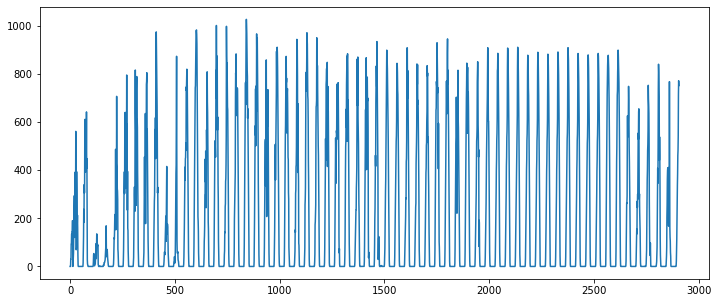

In [20]:
#Visualizations irradiance vs date
df['irradiance'].plot(figsize=(12,5))

In [21]:
#Performing the adfuller_test to check if the data is statinary or not

#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(dataset):
    result=adfuller(dataset)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), Data  is stationary")
    else:
        print("weak evidence against null hypothesis, indicating Data is non-stationary ")
        
adfuller_test(df['irradiance'])

ADF Test Statistic : -19.22331131690524
p-value : 0.0
#Lags Used : 28
Number of Observations Used : 2877
strong evidence against the null hypothesis(Ho), Data  is stationary


In [22]:
#Running auto arima to find the best arima parameters
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['irradiance'], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=33226.665, Time=3.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=41057.378, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=33779.281, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=38056.990, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42226.777, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=33615.011, Time=1.42 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=33236.748, Time=2.13 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.12 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=33237.335, Time=3.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=33716.976, Time=0.65 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=33500.470, Time=1.70 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=33218.178, Time=2.73 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=33501.069, Time=0.44 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=33221.466, Time=2.92 sec
 ARIMA(2,0,0)(0,0,0)[0] i

In [23]:
#splitting the dataset into train and test set. 30% of the data is reserved in the test set
print(df.shape)
train=df.iloc[:-873]
test=df.iloc[-873:]
print(train.shape,test.shape)

(2906, 2)
(2033, 2) (873, 2)


In [24]:
#training the model with arima and checking the summary of the coefficients
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['irradiance'],order=(3,0,1))
model=model.fit() #fittng the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             irradiance   No. Observations:                 2033
Model:                     ARMA(3, 1)   Log Likelihood              -11796.338
Method:                       css-mle   S.D. of innovations             80.054
Date:                Wed, 06 Jan 2021   AIC                          23604.676
Time:                        21:10:09   BIC                          23638.379
Sample:                             0   HQIC                         23617.041
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              198.2535      8.820     22.478      0.000     180.967     215.540
ar.L1.irradiance     1.7693      0.027     64.398      0.000       1.715       1.823
ar.L2.irradiance    -0.6403      0.050    -12.875      0.000      -0.738      -0.543
ar.L3.irradiance    -0.1530      0.024     -6.318      0.000      -0.200      -0.106
ma.L1.irradiance    -0.8808      0.018    -47.786      0.000      -0.917      -0.845
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0149           -0.1469j            1.0255           -0.0229
AR.2            1.0149           +0.1469j            1.0255            0.0229
AR.3           -6.2143           -0.0000j            6.2143           -0.5000
MA.1            1.1353           +0.0000j            1.1353            0.0000
-----------------------------------------------------------------------------
"""

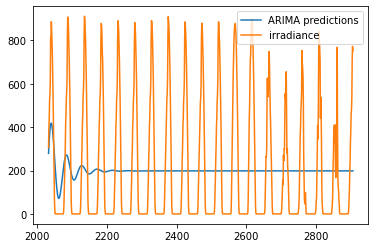

In [25]:
#Checking for the predictions
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA predictions')
pred.plot(legend=True)
test['irradiance'].plot(legend=True)

This happens when historical data doesn't have strong seasonality and the forecasting model finds it difficult to predict the future data points therefore it simply takes the average of the previous values and predict as future. Therefore, getting straight line.

In [26]:
#Performance Measurments

mean_y=test['irradiance'].mean() #calculating the mean irradiance

rmse=sqrt(mean_squared_error(pred,test['irradiance']))
print("RMSE=",rmse)

nrmse=rmse/mean_y
print("NRMSE=",nrmse)

r2 = r2_score(test['irradiance'], pred)
print("R2 Score=",r2)

RMSE= 280.0123768940577
NRMSE= 1.3727997817643518
R2 Score= 0.045991684678579836


In [27]:
#training the model with the entire datset.
model2=ARIMA(df['irradiance'],order=(3,0,1))
model2=model2.fit()

In [28]:
#Future date_time calculations
index_future_datetime=pd.date_range("06:00", "13:00", freq="30min") # Considering 6am to 1pm (According the datsets)
pred=model2.predict(start=len(df),end=len(df)+14,typ='levels',).rename('ARIMA Predictions') #6am-1pm=7 hours= 14 half hour intervals
pred.index=index_future_datetime
print(pred)

2021-01-06 06:00:00    746.660805
2021-01-06 06:30:00    727.112663
2021-01-06 07:00:00    697.121578
2021-01-06 07:30:00    657.517657
2021-01-06 08:00:00    609.665831
2021-01-06 08:30:00    555.010444
2021-01-06 09:00:00    495.082039
2021-01-06 09:30:00    431.454928
2021-01-06 10:00:00    365.710796
2021-01-06 10:30:00    299.403331
2021-01-06 11:00:00    234.025202
2021-01-06 11:30:00    170.977941
2021-01-06 12:00:00    111.545266
2021-01-06 12:30:00     56.870272
2021-01-06 13:00:00      7.936804
Freq: 30T, Name: ARIMA Predictions, dtype: float64


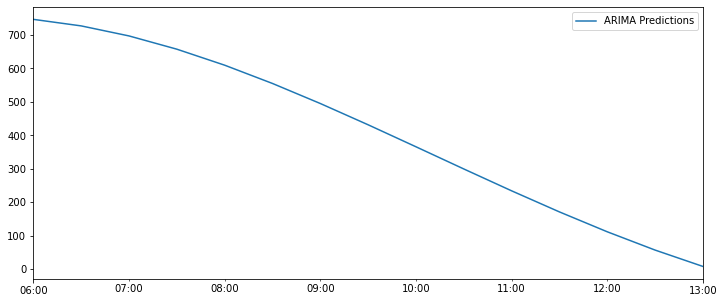

In [29]:
pred.plot(figsize=(12,5),legend=True) #plotting the predictions

In [33]:
index_future_datetime

DatetimeIndex(['2021-01-06 06:00:00', '2021-01-06 06:30:00',
               '2021-01-06 07:00:00', '2021-01-06 07:30:00',
               '2021-01-06 08:00:00', '2021-01-06 08:30:00',
               '2021-01-06 09:00:00', '2021-01-06 09:30:00',
               '2021-01-06 10:00:00', '2021-01-06 10:30:00',
               '2021-01-06 11:00:00', '2021-01-06 11:30:00',
               '2021-01-06 12:00:00', '2021-01-06 12:30:00',
               '2021-01-06 13:00:00'],
              dtype='datetime64[ns]', freq='30T')

In [31]:
predictions = pd.DataFrame(data=pred)

In [32]:
#predictions.to_csv("ARIMA Predictions.csv")